In [11]:
import pandas as pd
import polars as pl
import numpy as np
import plotnine as pn
from mizani.formatters import comma_format, custom_format, currency_format, percent_format
from IPython.display import clear_output, display
import os
import yfinance as yf
import itertools

pd.set_option('display.max.columns', 500)
background_colour = "#F2F2F2"
pn.theme_set(pn.theme_classic() + 
          pn.theme(text=pn.element_text(family="monospace"),
                plot_background=pn.element_rect(fill=background_colour, colour=background_colour),
                panel_background=pn.element_rect(fill=background_colour, colour=background_colour),
                legend_background=pn.element_rect(fill=background_colour, colour=background_colour)))

%load_ext blackcellmagic
%matplotlib inline

The blackcellmagic extension is already loaded. To reload it, use:
  %reload_ext blackcellmagic


## Yahoo Finance Exchange Rates

In [42]:
rates = (
    pd.DataFrame(
        itertools.permutations(["EUR", "CHF", "USD"], r=2), columns=["from", "to"]
    )
    .assign(name=lambda x: x["from"] + x["to"] + "=X")["name"]
    .tolist()
)

rates

['EURCHF=X', 'EURUSD=X', 'CHFEUR=X', 'CHFUSD=X', 'USDEUR=X', 'USDCHF=X']

In [49]:
dfs = []

for rate in rates:
    data = yf.download(rate, period="max", interval="1d")
    data = data.reset_index().assign(rate=rate)

    dfs.append(data)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [51]:
df = pd.concat(dfs, axis=0)
df

,Date,Open,High,Low,Close,Adj Close,Volume,rate
0,2003-01-23,1.46330,1.46500,1.46200,1.46420,1.46420,0,EURCHF=X
1,2003-01-24,1.46440,1.46760,1.46200,1.46730,1.46730,0,EURCHF=X
2,2003-01-27,1.46640,1.46920,1.46520,1.46760,1.46760,0,EURCHF=X
3,2003-01-28,1.46760,1.47030,1.46650,1.46830,1.46830,0,EURCHF=X
4,2003-01-29,1.46780,1.47030,1.46510,1.46930,1.46930,0,EURCHF=X
...,...,...,...,...,...,...,...,...
5353,2024-04-16,0.91160,0.91409,0.91123,0.91160,0.91160,0,USDCHF=X
5354,2024-04-17,0.91256,0.91317,0.90940,0.91256,0.91256,0,USDCHF=X
5355,2024-04-18,0.91040,0.91213,0.90790,0.91040,0.91040,0,USDCHF=X
5356,2024-04-19,0.91210,0.91265,0.90183,0.91210,0.91210,0,USDCHF=X


Daily data is not ideal here, it would be to have higher frequencies to spot interesting patterns. In reality, order book data is what we would need.

In [63]:
df = (
    df.filter(["Date", "Close", "rate"])
    .pivot(index="Date", columns="rate", values="Close")
    .reset_index()
    .rename_axis(None, axis=1)
    .dropna()
    .reset_index(drop=True)
)

df.head()

,Date,CHFEUR=X,CHFUSD=X,EURCHF=X,EURUSD=X,USDCHF=X,USDEUR=X
0,2005-03-16,0.64654,0.867378,1.5463,1.341094,1.1529,0.74566
1,2005-03-17,0.64558,0.864006,1.5484,1.337900,1.1574,0.74744
2,2005-03-18,0.64479,0.859402,1.5501,1.332197,1.1636,0.75064
3,2005-03-21,0.64437,0.848248,1.5512,1.316101,1.1789,0.75982
4,2005-03-22,0.64329,0.841043,1.5546,1.307702,1.1890,0.76470


## Two Way Trades

In [115]:
combinations = pd.DataFrame(itertools.permutations(["EUR", "CHF", "USD"], 2), columns=["from", "to"])
combinations

,from,to
0,EUR,CHF
1,EUR,USD
2,CHF,EUR
3,CHF,USD
4,USD,EUR
5,USD,CHF


In [146]:
pairs = []

for combination in combinations.iterrows():
    first = combination[1]["from"] + combination[1]["to"] + "=X"
    second = combination[1]["to"] + combination[1]["from"] + "=X"

    pair = (
        df
        .filter([first, second])
        .assign(
            result=lambda x: x.iloc[:, 0] * x.iloc[:, 1],
            pair=lambda x: x.columns[0][:-2],
        )
        .filter(["pair", "result"])
    )

    pairs.append(pair)

In [147]:
twoway = pd.concat(pairs, axis=0).reset_index(drop=True)
twoway.head()

,pair,result
0,EURCHF,0.999745
1,EURCHF,0.999616
2,EURCHF,0.999489
3,EURCHF,0.999547
4,EURCHF,1.000059


In [148]:
twoway.pair.value_counts()

pair
EURCHF    4952
EURUSD    4952
CHFEUR    4952
CHFUSD    4952
USDEUR    4952
USDCHF    4952
Name: count, dtype: int64

In [149]:
twoway.groupby("pair").agg(["min", "mean", "max"])

result                    
            min      mean       max
pair                               
CHFEUR  0.98105  0.999719  1.000937
CHFUSD  1.00000  1.000000  1.000000
EURCHF  0.98105  0.999719  1.000937
EURUSD  1.00000  1.000000  1.000000
USDCHF  1.00000  1.000000  1.000000
USDEUR  1.00000  1.000000  1.000000

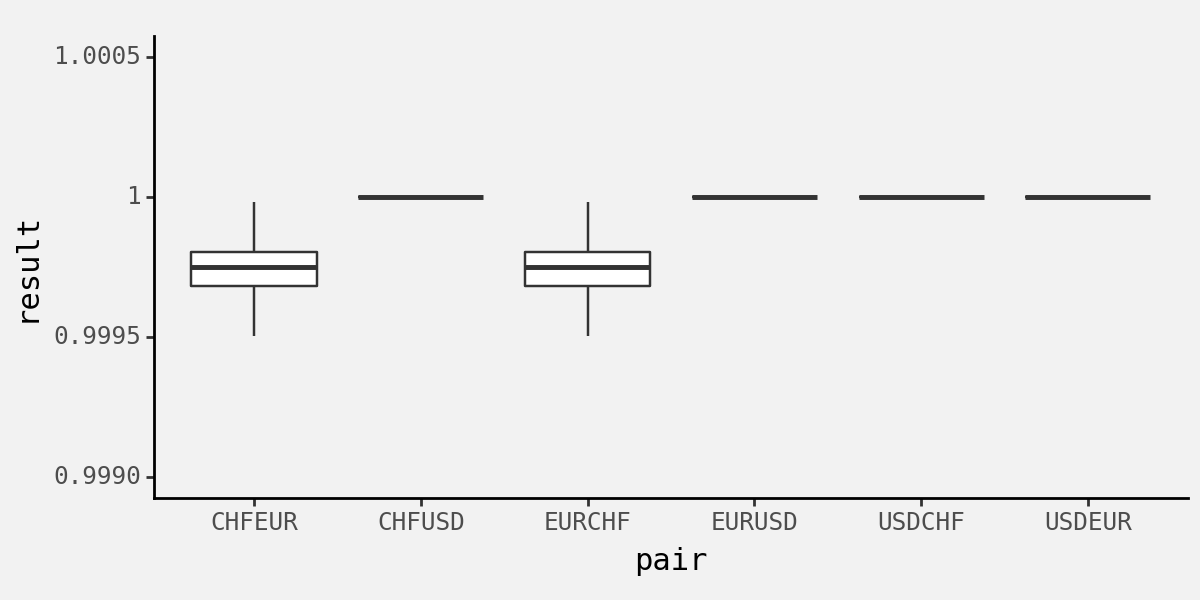

<Figure Size: (600 x 300)>

In [150]:
(
    pn.ggplot(data=twoway, mapping=pn.aes(y="result", x="pair"))
    + pn.geom_boxplot(outlier_colour="none")
    + pn.coord_cartesian(ylim=[0.999, 1.0005])
    + pn.theme(figure_size=[6, 3])
)

## Three Way

In [152]:
combinations = pd.DataFrame(itertools.permutations(["EUR", "CHF", "USD"], 3), columns=["base", "first", "second                                                                                       "])
combinations

,base,first,second
0,EUR,CHF,USD
1,EUR,USD,CHF
2,CHF,EUR,USD
3,CHF,USD,EUR
4,USD,EUR,CHF
5,USD,CHF,EUR


In [ ]:
pairs = []

for combination in combinations.iterrows():
    # base to first
    first = combination[1]["from"] + combination[1]["to"] + "=X"
    # first to second
    second = combination[1]["to"] + combination[1]["from"] + "=X"
    # second to base

    pair = (
        df
        .filter([first, second])
        .assign(
            result=lambda x: x.iloc[:, 0] * x.iloc[:, 1],
            pair=lambda x: x.columns[0][:-2],
        )
        .filter(["pair", "result"])
    )

    pairs.append(pair)

In [ ]:
twoway = pd.concat(pairs, axis=0).reset_index(drop=True)
twoway.head()

,pair,result
0,EURCHF,0.999745
1,EURCHF,0.999616
2,EURCHF,0.999489
3,EURCHF,0.999547
4,EURCHF,1.000059


In [ ]:
twoway.pair.value_counts()

pair
EURCHF    4952
EURUSD    4952
CHFEUR    4952
CHFUSD    4952
USDEUR    4952
USDCHF    4952
Name: count, dtype: int64

In [ ]:
twoway.groupby("pair").agg(["min", "mean", "max"])

result                    
            min      mean       max
pair                               
CHFEUR  0.98105  0.999719  1.000937
CHFUSD  1.00000  1.000000  1.000000
EURCHF  0.98105  0.999719  1.000937
EURUSD  1.00000  1.000000  1.000000
USDCHF  1.00000  1.000000  1.000000
USDEUR  1.00000  1.000000  1.000000

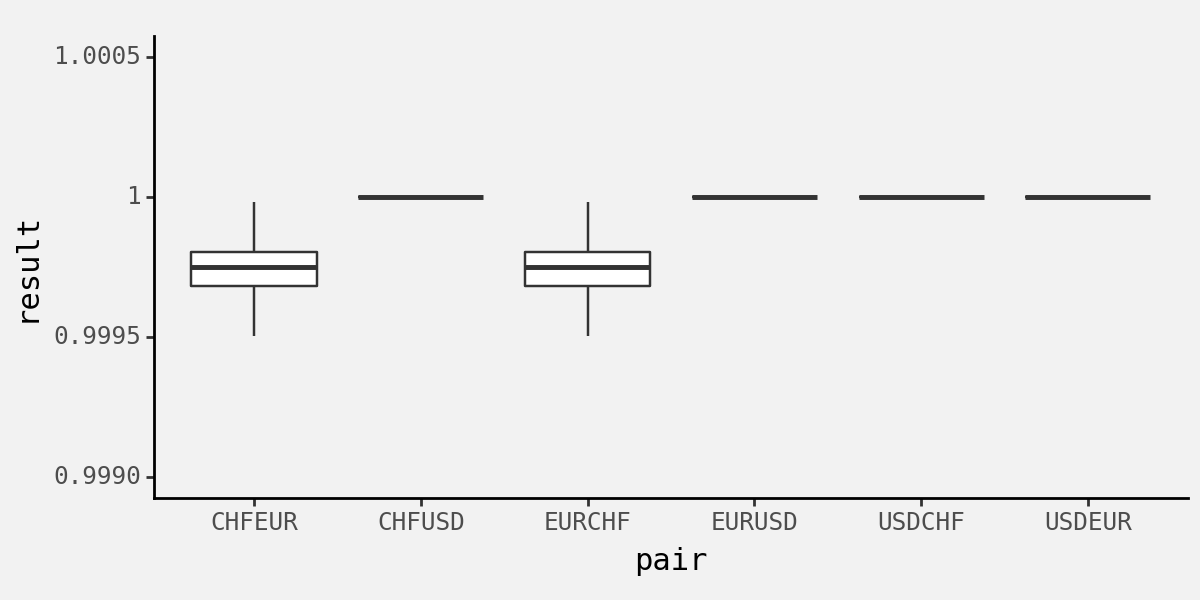

<Figure Size: (600 x 300)>

In [ ]:
(
    pn.ggplot(data=twoway, mapping=pn.aes(y="result", x="pair"))
    + pn.geom_boxplot(outlier_colour="none")
    + pn.coord_cartesian(ylim=[0.999, 1.0005])
    + pn.theme(figure_size=[6, 3])
)